In [140]:
import cv2
import dlib
from PIL import Image
import imutils
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.decomposition import PCA
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

In [142]:
# Displayinh the number of GPUs available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1


In [143]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)

In [144]:
# load a test image, resize it, and convert it to grayscale
def load_image(path, show=False, gray_show=False):
    test_image = cv2.imread(path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    test_image = imutils.resize(test_image, width=500)
    gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

    if show:
        plt.imshow(test_image)
        plt.show()
        if gray_show:
            plt.imshow(gray, cmap='gray')
            plt.show()
    return test_image, gray

def detect_faces(face_detector, gray, img, scale_factor, frame_num, show_multi_faces = False):
    detections = haar_cascade.detectMultiScale(gray, scaleFactor=scale_factor, minNeighbors=5, minSize=(150, 150), flags=cv2.CASCADE_SCALE_IMAGE)
    #Checking if there are more than 1 detected faces
    if len(detections) > 1:
        print('Multiple faces detected', frame_num)
        return False
    elif len(detections) == 1:
        face = detections[0]
    # if no face detected
    elif len(detections) == 0:
        print('No face detected', frame_num)
        return False
    fX, fY, fW, fH = face[0], face[1], face[2], face[3]
    face_img = Image.fromarray(img[fY:fY + fH, fX:fX + fW])
    face_img = face_img.resize((224, 224))
    #face_img.show()
    return face_img

In [145]:
def get_face(path, face_detector, model, scale_factor):
    test_img, gray = load_image(path, show=False)
    face = detect_faces(face_detector, gray, test_img, scale_factor, 1, show_multi_faces=False)

    if not face:
        return 0, False

    face_array = np.asarray(face)
    # pixels = face_array.astype('float32')
    # samples = np.expand_dims(pixels, axis=0)
    # samples = preprocess_input(samples, version=2)
    # embedding = model.predict(samples, verbose=0)
    # embeddings.append(embedding[0])
    return tf.convert_to_tensor(face_array, dtype=tf.uint8), True

In [146]:
# haar Cascade path
cascade_path = '../models/haarcascade_frontalface_default.xml'
# create haar cascade
haar_cascade = cv2.CascadeClassifier(cascade_path)
face_detector = 'haar'

frame_start = 80000
frame_end = 80010
frames = range(frame_start, frame_end + 1)

scale_factor = 1.04

folder_path = '../frames/P11401/sleepy/frame'

In [147]:
import gc
gc.collect()

22043

In [148]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=100)])
#   except RuntimeError as e:
#     print(e)
    
print("GPU is set")

GPU is set


In [149]:
model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

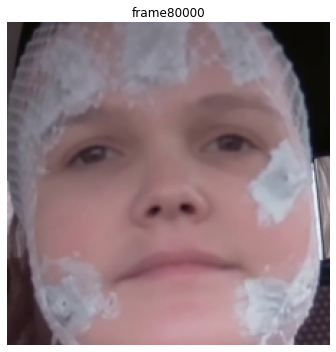

In [150]:
frame = 80000
path = folder_path + str(frame) + '.jpg'
face = get_face(path, face_detector, model, scale_factor)[0]

plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
ax.imshow(face)
ax.set_title(path[-14:-4])
ax.axis('off')
plt.tight_layout()
plt.show()

In [151]:
baseline =tf.zeros(shape=(224,224,3), dtype=tf.uint8)

In [152]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    delta = tf.cast(delta, tf.float32)
    baseline_x = tf.cast(baseline_x, tf.float32)
    images = baseline_x +  alphas_x * delta
    return images

gc.collect()
interpolated_images = interpolate_images(baseline=baseline, image=face, alphas=alphas)
interpolated_images_int = tf.cast(interpolated_images, tf.uint8)


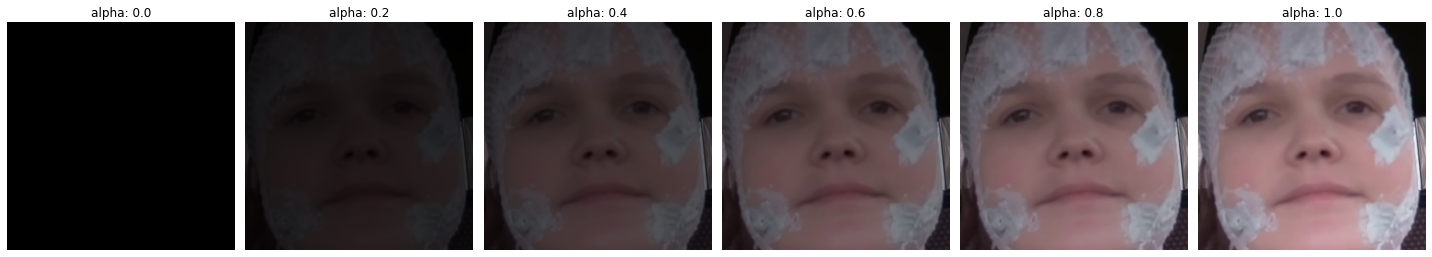

In [153]:
gc.collect()

fig = plt.figure(figsize=(20, 20))
i = 0
for alpha, image in zip(alphas[0::10], interpolated_images_int[0::10]):
    i += 1
    plt.subplot(1, len(alphas[0::10]), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout();

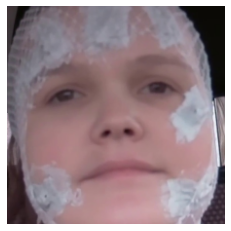

[ 521  721 1548] tf.Tensor([0.68856347 0.27088714 0.03403028], shape=(3,), dtype=float32)


In [154]:
def top_k_predictions(img, k=3):
    image = tf.expand_dims(img, 0)
    predictions = model(image)
    probs = tf.nn.softmax(predictions, axis=-1)
    top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
    top_labels = np.array(tuple(top_idxs[0]) )
    return top_labels, top_probs[0]

#Display the image with top 3 prediction from the model
plt.imshow(face)
plt.axis('off')
plt.show()
pred_label, pred_prob = top_k_predictions(face)
print(pred_label, pred_prob)
target_class = pred_label[0]

In [155]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)
path_gradients = compute_gradients(images=interpolated_images, target_class_idx=target_class)

In [156]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [157]:
def integrated_gradients(baseline, image, target_class_idx, m_steps=50, batch_size=1):
    # 1. Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
    # Initialize TensorArray outside loop to collect gradients.    
    gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)
    
    # Iterate alphas range and batch computation for speed, memory #efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]
        
    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline, image=image, alphas=alpha_batch)
    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch, target_class_idx=target_class_idx)
    
    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    
  
    # Stack path gradients together row-wise into single tensor.
    total_gradients = gradient_batches.stack()
    # 4. Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)
    # 5. Scale integrated gradients with respect to input.
    image = tf.cast(image, tf.float32)
    baseline = tf.cast(baseline, tf.float32)

    integrated_gradients = (image - baseline) * avg_gradients
    return integrated_gradients
ig_attributions = integrated_gradients(baseline=baseline, image=face, target_class_idx=target_class, m_steps=283)

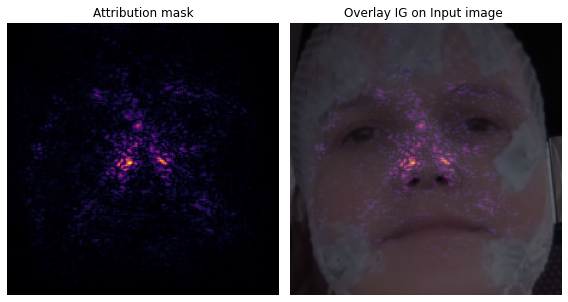

In [158]:
def plot_img_IG(baseline, image, target_class_idx, m_steps=50, cmap=None, overlay_alpha=0.4):
    attributions = integrated_gradients(baseline=baseline, image=image, target_class_idx=target_class_idx, m_steps=m_steps)
    #print(attributions)
    #attributions = tf.cast(attributions, tf.int8)
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
    fig, axs = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=   (8, 8))
    axs[0, 0].set_title('Attribution mask')
    axs[0, 0].imshow(attribution_mask, cmap=cmap)
    axs[0, 0].axis('off')
    axs[0, 1].set_title('Overlay IG on Input image ')
    axs[0, 1].imshow(attribution_mask, cmap=cmap)
    axs[0, 1].imshow(image, alpha=overlay_alpha)
    axs[0, 1].axis('off')
    plt.tight_layout()
    plt.savefig('../figures/igg_sub10_normal.jpg')
    return fig
_ = plot_img_IG(image=face, baseline=baseline, target_class_idx=target_class, m_steps=240, cmap=plt.cm.inferno, overlay_alpha=0.4)

In [163]:
# haar Cascade path
cascade_path = '../models/haarcascade_frontalface_default.xml'
# create haar cascade
haar_cascade = cv2.CascadeClassifier(cascade_path)
face_detector = 'haar'

frame_start = 90000
frame_end = 110000
frames = range(frame_start, frame_end + 1)

scale_factor = 1.025

folder_path = '../frames/P11401/sleepy/frame'

baseline =tf.zeros(shape=(224,224,3), dtype=tf.uint8)

def get_multiple_ig(frames, face_detector, model, scale_factor, folder_path, baseline):
    ig_list = []
    for frame in frames:
        if frame % 1000 == 0:
            print(frame)
        path = folder_path + str(frame) + '.jpg'
        face, boolean = get_face(path, face_detector, model, scale_factor)
        if boolean == False:
            continue
        pred_label, pred_prob = top_k_predictions(face)
        target_class = pred_label[0]
        ig_attributions = integrated_gradients(baseline=baseline, image=face, target_class_idx=target_class, m_steps=283)
        ig_list.append(ig_attributions)
    return ig_list, face

ig_values, face = get_multiple_ig(frames, face_detector, model, scale_factor, folder_path, baseline)
print(len(ig_values))

90000
91000
92000
93000
94000
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
No face detected 1
95000
Multiple faces detected 1
Multiple faces detected 1
Multiple faces detected 1
Multiple faces detected 1
Multiple faces detected 1
Multiple faces detected 1
Multiple faces detected 1
Multiple faces detected 1
Multiple faces detected 1
Multiple faces detected 1
Multiple faces detected 1
Multiple faces detected 1
Multiple faces detected 1
Multiple faces det

2023-02-11 21:30:33.225479: I tensorflow/stream_executor/cuda/cuda_driver.cc:733] failed to allocate 8.73G (9374215680 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-02-11 21:30:33.227668: I tensorflow/stream_executor/cuda/cuda_driver.cc:733] failed to allocate 8.73G (9374215680 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

2023-02-11 21:30:43.430407: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7f18ba739000 of size 602112 next 12052
2023-02-11 21:30:43.430420: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7f18ba7cc000 of size 602112 next 11901
2023-02-11 21:30:43.430433: I tensorflow/core/common_runt

ResourceExhaustedError: {{function_node __wrapped__RealDiv_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:RealDiv]

In [ ]:
def get_aggregated_ig(ig_values):
    num = len(ig_values)
    print(tf.shape(ig_values[0]))
    sum_values = sum(ig_values)
    agg_ig = sum_values / num
    print(tf.shape(agg_ig))
    return agg_ig
    
agg_ig = get_aggregated_ig(ig_values)
print(len(ig_values))

In [ ]:
frame = 90000
path = folder_path + str(frame) + '.jpg'
face = get_face(path, face_detector, model, scale_factor)[0]

def plot_img_IG(face, agg_ig, cmap=None, overlay_alpha=0.4):
    attribution_mask = tf.reduce_sum(tf.math.abs(agg_ig), axis=-1)
    fig, axs = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=   (8, 8))
    axs[0, 0].set_title('Attribution mask')
    axs[0, 0].imshow(attribution_mask, cmap=cmap)
    axs[0, 0].axis('off')
    axs[0, 1].set_title('Overlay IG on Input image ')
    axs[0, 1].imshow(attribution_mask, cmap=cmap)
    axs[0, 1].imshow(face, alpha=overlay_alpha)
    axs[0, 1].axis('off')
    plt.tight_layout()
    plt.savefig('../figures/agg_ig_test.jpg')
    return fig
_ = plot_img_IG(face, agg_ig, cmap=plt.cm.inferno, overlay_alpha=0.4)